# 8. Dimensionality Reduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/0xInode/AI-study-notes/blob/main/ml/hands-on-ml/chapter08/chapter08.ipynb)


머신러닝 문제는 각 훈련 샘플마다 수천 - 수백만 개의 특성 포함  
이러한 모든 특성은 훈련을 매우 느리게 만들 뿐만 아니라 좋은 해법을 찾기 어렵게 만듦  
-> 차원의 저주(curse of dimensionality)

특성 수를 상당히 줄여 불가능한 문제를 해결 가능한 문제로 바꾸는 것이 종종 가능

3장에서 소개된 MNIST 이미지의 경우
- 이미지 테두리의 픽셀은 거의 항상 흰색이므로 이 픽셀을 훈련 세트에서 완전히 제거해도 정보 손실이 거의 없음
- 또한 인접한 두 픽셀은 종종 높은 상관관계를 가지므로
이 둘을 하나의 픽셀로 병합(예: 두 픽셀 강도의 평균 사용)하면 정보 손실이 거의 없음

차원 축소는 일부 정보 손실을 수반  
(이미지를 JPEG로 압축하면 품질이 저하되는 것과 같음)  
-> 훈련 속도는 빨라지지만 시스템의 성능이 약간 떨어질 수 있음

파이프라인을 더 복잡하게 만들어 유지 관리가 어려워짐  
그러므로 훈련 속도가 너무 느릴 경우 차원 축소를 사용하기 전에 먼저 원본  데이터를 그대로 사용해 시스템을 훈련해 보는 것이 좋음  

어떤 경우에는 차원 축소가 훈련 데이터의 노이즈나 불필요한 세부 정보를 걸러내어 성능을 높일 수도 있지만, 일반적으로는 성능 향상이 아닌 **훈련 속도 향상이 목적**

훈련 속도를 높이는 것 외에도 데이터 시각화(DataViz)에 매우 유용  
차원을 2개(또는 3개)로 줄이면 고차원 훈련 세트를 그래프 상에서 축약된 형태로 시각화할 수 있음  
이를 통해 클러스터와 같은 패턴을 시각적으로 탐지하여 중요한 통찰을 얻을 수 있음  
또한 DataViz는 데이터 과학자가 아닌 사람, 특히 결과를 활용할 의사결정권자에게 결론을 전달하는 데 필수적

## Setup

In [3]:
import sys

assert sys.version_info >= (3, 7)

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The Curse of Dimensionality

우리는 3차원 공간에 익숙하기 때문에 고차원 공간을 상상하려 하면 직관이 무너짐  
기본적인 4차원 초입방체조차 머릿속에서 그리기 매우 어려움  
하물며 1,000차원 공간 속에 구부러진 200차원 타원체는 더더욱 상상하기 어려움

고차원 공간에서는 많은 것이 매우 다르게 작동함  
예를 들어 단위 정사각형(1 × 1)에서 임의의 점을 선택할 경우  
그 점이 경계로부터 0.001보다 가까이 있을 확률은 약 0.4%에 불과함  
즉, 임의의 점이 어떤 차원에서 극단적일 가능성은 매우 낮음  
하지만 10,000차원 단위 초입방체에서는 이 확률이 99.999999%를 넘음  
대부분의 점이 경계에 매우 가까움

단위 정사각형에서 임의로 두 점을 고르면 두 점 사이의 평균 거리는 약 0.52  
단위 3차원 정육면체에서는 평균 거리가 약 0.66  

1,000,000차원 초입방체에서 두 점을 임의로 고르면?  
평균 거리는 약 408.25(대략 1,000,000 ÷ 6)  
→ **직관에 어긋남**

어떻게 두 점이 같은 단위 초입방체 안에 있으면서도 이렇게 멀 수 있을까  
그 이유는 고차원 공간에는 그만큼 엄청난 여유 공간이 있기 때문

이로 인해 고차원 데이터셋은 매우 **희소(sparse)**해질 위험  
→ 대부분의 훈련 샘플들이 서로 멀리 떨어져 있게 됨  
→ 따라서 새로운 샘플도 기존 훈련 샘플과 멀리 떨어져 있을 가능성이 높음  
→ 예측이 저차원보다 **훨씬 큰 외삽(extrapolation)**에 의존하게 되어 신뢰도가 떨어짐

> 훈련 세트의 차원이 많아질수록 **과적합(overfitting)**의 위험이 커짐

이론적으로 차원의 저주를 해결하려면 훈련 샘플 수를 증가시키는 방안이 있음  
(훈련 샘플 간 밀도를 높이면 희소성을 줄일 수 있으므로)

하지만 실제로는  
차원이 늘어날수록 필요한 훈련 샘플 수는 지수적으로 증가  
특성이 100개뿐이라도  
모든 차원에 걸쳐 고르게 퍼졌다고 가정,  
각 샘플이 평균적으로 서로 0.1 이내에 있도록 하려면  
관측 가능한 우주의 원자 수보다 많은 훈련 샘플이 필요  

## Main Approaches for Dimensionality Reduction

차원 축소의 두 가지 주요 접근 방식
- 투영(projection)
- 매니폴드 학습(Manifold Learning)

### Projection

현실 세계의 대부분 문제에서 훈련 샘플은 모든 차원에 걸쳐 균일하게 퍼져 있지 않음
- 많은 특성은 거의 값이 일정
- 일부 특성은 서로 강한 상관관계
- 그 결과 모든 훈련 샘플은 고차원 공간의 훨씬 낮은 차원의 부분공간(subspace) 안에(또는 그 근처에) 존재

모든 훈련 샘플이 한 평면에 가까이 몰려 있음  
→ 이는 고차원(3D) 공간의 더 낮은 차원(2D) 부분공간

모든 훈련 샘플을 이 부분공간에 수직으로 투영하면    
(각 샘플에서 평면까지 이어지는 짧은 선으로 표시됨)  
새로운 2차원 데이터셋이 만들어짐

이렇게 해서 데이터의 차원을 3D에서 2D로 줄인 것임    
이때 축은 새로운 특성 $𝑧_1$, $𝑧_2$에 해당(평면 위 투영점의 좌표)

하지만 투영이 항상 차원 축소에 최적의 방법은 아님  
많은 경우, 부분공간이 구부러지고 뒤틀려 있음  
→ Swiss roll(스위스 롤) 장난감 데이터셋이 대표적 예시

단순히 한 평면에 투영하는 방식(예: 𝑥3을 버리는 방식)은  
Swiss roll의 서로 다른 층들이 짓눌려 겹쳐지게 됨

실제로 원하는 것은 Swiss roll을 펴서 펼친 뒤  
진짜 2차원 구조를 얻는 것

### Manifold Learning

Swiss roll은 **2차원 매니폴드(2D manifold)**의 예시  
2차원 매니폴드는 고차원 공간 안에서 구부러지거나 휘어질 수 있는 2차원 형태

d차원 매니폴드:
d < n인 경우, n차원 공간의 일부로서 국소적으로는 d차원 초평면처럼 보이는 구조

Swiss roll의 경우 d = 2, n = 3  
→ 지역적으로는 2D 평면처럼 보이지만, 실제로는 3차원 공간 안에서 말려 있음

많은 차원 축소 알고리즘은 훈련 샘플들이 놓여 있는 이 매니폴드를 모델링함
→ **매니폴드 학습(Manifold Learning)**

이는 **매니폴드 가정(manifold assumption 또는 manifold hypothesis)**에 기반
→ 대부분의 현실 고차원 데이터셋은 훨씬 낮은 차원의 매니폴드 근처에 존재한다는 가정(실제로 자주 관찰됨)

MNIST 데이터셋의 경우  
모든 손글씨 숫자 이미지는 몇 가지 공통된 특징 가짐
- 선들이 연결되어 있음
- 배경은 하얗고
- 대체로 가운데에 위치

이미지를 무작위로 생성하면 그중 극소수만이 실제 손글씨 숫자처럼 보일 것  
→ 손글씨 숫자를 생성할 때의 **자유도(degree of freedom)**는 임의의 이미지를 생성할 때보다 훨씬 낮음

이러한 제약들이 데이터셋을 더 낮은 차원의 매니폴드로 압축시키는 결과를 낳음

매니폴드 가정에 또 하나의 암묵적 가정  
→ 문제(예: 분류, 회귀)가 매니폴드 상의 저차원 공간에서 더 단순해진다는 가정

Swiss roll이 두 클래스로 나뉘어 있음  
3D 공간(왼쪽)에서는 복잡한 결정 경계가 필요  
2D로 펼친 매니폴드 공간(오른쪽)에서는 직선 경계로 충분  
(하지만 이 가정이 항상 맞는 것은 아님)

결정 경계 𝑥1=5  
원래 3D 공간에서는 단순한 수직 평면
하지만 매니폴드를 펼치면 복잡한 네 개의 선분 조각


>훈련 세트를 차원 축소하면 훈련 속도는 일반적으로 빨라지지만
해법이 더 단순하거나 더 나은 것이 될지는 데이터셋에 따라 다름

## PCA

**주성분 분석(PCA, Principal Component Analysis)**  
- 가장 널리 사용되는 차원 축소 알고리즘
- 우선 데이터에 **가장 가까운 초평면(hyperplane)**을 찾고
- 그 다음 데이터를 그 초평면에 투영


### Preserving the Variance

훈련 세트를 더 낮은 차원의 초평면에 투영하기 전에
먼저 적절한 초평면을 선택

다음 그림 왼쪽에는 세 개의 서로 다른 축(1차원 초평면)이 표시  
오른쪽에는 각 축에 대해 데이터셋을 투영한 결과
- 실선(solid line)에 투영한 경우: 분산이 최대로 보존됨
- 점선(dotted line)에 투영한 경우: 분산이 거의 없음
- 파선(dashed line)에 투영한 경우: 중간 정도 분산이 보존됨

→ 가장 많은 **분산(variance)**을 보존하는 축을 선택하는 것이 합리적으로 보임  
→ 이는 다른 축에 비해 정보 손실이 가장 적을 가능성이 높음

또 다른 관점에서 보면  
이 축은 **원본 데이터와 투영된 데이터 간 평균 제곱 거리(mean squared distance)**를 최소화하는 축  
=> PCA의 핵심 아이디어

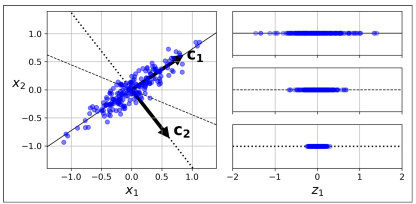

### Principal Components

1. PCA는 훈련 세트에서 분산이 가장 큰 방향의 축을 찾음(위 그림의 실선)
2. 그 다음에는 첫 번째 축과 직교하는 두 번째 축을 찾아
3. 남은 분산 중 가장 많은 양을 설명하는 방향을 찾음
(2차원 예시에서는 선택의 여지가 없으며, 점선이 두 번째 축)
4. 데이터가 더 높은 차원일 경우
PCA는 세 번째 축, 네 번째 축 등 **모든 차원 수만큼의 직교 축(principal components, PCs)**을 찾아냄

각 축은 해당 순서의 **주성분(PC, Principal Component)**  
=> 위 그림에서 첫 번째 주성분은 벡터 𝑐1이 놓인 축  
두 번째 주성분은 벡터 𝑐2이 놓인 축

그림 8-2에서는
첫 두 개의 주성분이 평면 위의 두 개의 직교 화살표
세 번째 주성분은 그 평면에 수직인 축
PCA는 각 주성분마다 방향을 나타내는
**단위 벡터(길이 1이고 중심이 원점인 벡터)**를 구함

→ 이 벡터는 방향만 정의하므로,
벡터가 반대 방향을 가리키더라도 동일한 축임
→ 훈련 세트에 조금이라도 변동이 생기면
벡터 방향이 바뀔 수 있지만, 여전히 같은 축을 나타냄
→ 경우에 따라 벡터 쌍이 서로 바뀔 수도 있음
(해당 축들의 분산이 비슷할 경우),
그러나 이들이 정의하는 평면 자체는 유지됨

그럼 어떻게 주성분을 찾을 수 있을까?
**특이값 분해(SVD, Singular Value Decomposition)**라는
표준 행렬 분해 기법을 사용함

→ 훈련 세트 행렬 𝑋
X를 다음 세 행렬 곱으로 분해함
𝑋=𝑈Σ𝑉⊤

여기서 **𝑉**는 우리가 원하는
주성분 방향 벡터들을 담고 있음
→ 𝑉=[𝑐1  𝑐2  …  𝑐𝑛]

### Projecting Down to d Dimensions

### Using Scikit-Learn

### Explained Variance Ratio

### Choosing the Right Number of Dimensions

### PCA for Compression

### Randomized PCA

### Incremental PCA

## Kernel PCA

### Selecting a Kernel and Tuning Hyperparameters

## LLE

### Other Dimensionality Reduction Techniques